# Aerial Semantic Segmentation with U-Net Architecture

#### What is Semantic Segmentation?

**Semantic Segmentation** is a deep learning algorithm that associates a label or category with every single pixel in an image. The goal is to draw a careful outline around the object that is detected so that we know exactly which pixels belong to the object and which pixels don't. It attempts to label every pixel of an image. 

It is used to recognize a collection of pixels that form distinct categories (such as "background" and "foreground", or "road", "car" and "sidewalk"). This technique is used in applications such as image and video editing, autonumous driving, robotics, madical imaging and many more.

This project will attempt to use **U-Net** architecture for Semantic Segmentation. **U-Net** is an algorithm that consists of an *encoder* and a *decoder*. The encoder is used to *downsample* the image and the decoder is used to *upsample* the image. 

The key building block of **U-Net** is *transpose convolution* (opposite of convolution) of an input `(e.g. 2x2)` and blowing it up to a larger input `(e.g. 4x4)`



## Packages

In [1]:
import tensorflow as tf
import numpy as np

from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dropout 
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import concatenate

## Load and Split the Data

In [2]:
import os
import imageio
import pathlib
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt

%matplotlib inline

In [3]:
# Upload API's key JSON file
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"josephnkumah","key":"b433f6f9b0cce0bdba3dd4c2a394ecdb"}'}

In [4]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [5]:
!kaggle datasets download -d bulentsiyah/semantic-drone-dataset

100% 3.88G/3.89G [00:33<00:00, 133MB/s]
100% 3.89G/3.89G [00:33<00:00, 123MB/s]


In [6]:
!unzip -qq semantic-drone-dataset.zip

In [7]:
data_dir = os.path.join('dataset', 'semantic_drone_dataset')
image_path = os.path.join(data_dir, 'original_images/')
mask_path = os.path.join(data_dir, 'label_images_semantic/')

In [8]:
image_dir_list = os.listdir(image_path)
mask_dir_list = os.listdir(mask_path)

In [9]:
image_paths = [image_path+i for i in sorted(image_dir_list)]
mask_paths = [mask_path+i for i in sorted(mask_dir_list)]

In [10]:
import random

rand_img = random.randint(0, len(image_paths))
image_paths[rand_img], mask_paths[rand_img]

('dataset/semantic_drone_dataset/original_images/345.jpg',
 'dataset/semantic_drone_dataset/label_images_semantic/345.png')

In [11]:
random.Random(7).shuffle(image_paths)
random.Random(7).shuffle(mask_paths)

In [12]:
image_paths[rand_img], mask_paths[rand_img]

('dataset/semantic_drone_dataset/original_images/188.jpg',
 'dataset/semantic_drone_dataset/label_images_semantic/188.png')

### Display some masked and unmasked images from the dataset

<ipython-input-13-4e9bd76aecd7>:1: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(image_paths[rand_img])
<ipython-input-13-4e9bd76aecd7>:2: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  mask = imageio.imread(mask_paths[rand_img])


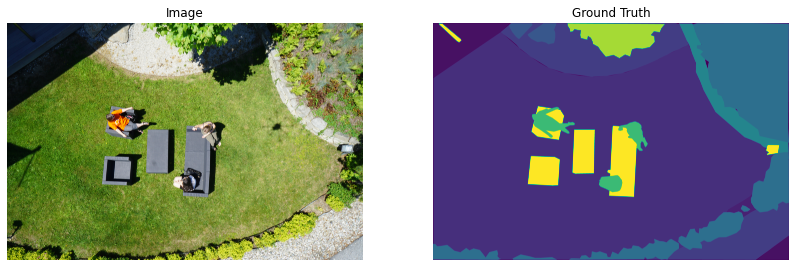

In [13]:
img = imageio.imread(image_paths[rand_img])
mask = imageio.imread(mask_paths[rand_img])

fig, arr = plt.subplots(1, 2, figsize=(14, 10))
arr[0].axis("off")
arr[0].set_title("Image")
arr[0].imshow(img)
arr[1].axis("off")
arr[1].set_title("Ground Truth")
arr[1].imshow(mask)

### Split Data into Train and Test Samples

In [14]:
num_train_samples = int((80/100) * len(image_paths)) 

# 80% of the data for training 
train_image_paths = image_paths[:num_train_samples]
train_mask_paths = mask_paths[:num_train_samples]

# 20% of the data for validation
val_image_paths = image_paths[num_train_samples:]
val_mask_paths = mask_paths[num_train_samples:]

In [15]:
# Cross-check the data
print("Total image data samples:", len(train_image_paths) + len(val_image_paths))
print("Total mask data samples:", len(train_mask_paths) + len(val_mask_paths))

Total image data samples: 400
Total mask data samples: 400


### Preprocess the Data

Create a `Dataset` to `tf.Tensor` objects and use `Dataset.from_tensor_slices`:

In [16]:
def conv_to_tftensor(image_paths, mask_paths):  
  image_filenames = tf.constant(image_paths)
  masks_filenames = tf.constant(mask_paths)

  dataset = tf.data.Dataset.from_tensor_slices((image_filenames, masks_filenames))

  return dataset

In [17]:
# Convert train image and mask paths to tf.tensor
train_ds = conv_to_tftensor(train_image_paths, train_mask_paths)

# Convert test image and mask paths to tf.tensor
val_ds = conv_to_tftensor(val_image_paths, val_mask_paths)

Check out some paths converted to tf.tensor

In [18]:
# Example of train tf.tensor sample
for train_image, train_mask in train_ds.take(1):
  print("Example of train tf.tensor sample:")
  print("image tf.tensor", train_image)
  print("Mask tf.tensor", train_mask, "\n")

# Example of validation tf.tensor sample
for val_image, val_mask in val_ds.take(1):
  print("Example of validation tf.tensor sample:")
  print("Validation image tf.tensor:", val_image)
  print("Validation mask tf.tensor", val_mask)  

Example of train tf.tensor sample:
image tf.tensor tf.Tensor(b'dataset/semantic_drone_dataset/original_images/062.jpg', shape=(), dtype=string)
Mask tf.tensor tf.Tensor(b'dataset/semantic_drone_dataset/label_images_semantic/062.png', shape=(), dtype=string) 

Example of validation tf.tensor sample:
Validation image tf.tensor: tf.Tensor(b'dataset/semantic_drone_dataset/original_images/332.jpg', shape=(), dtype=string)
Validation mask tf.tensor tf.Tensor(b'dataset/semantic_drone_dataset/label_images_semantic/332.png', shape=(), dtype=string)


Normalize normalize the image values using `tf.image.convert_image_dtype()` with `tf.float32`. This sets them between 0 and 1 

In [19]:
def process_path(image_path, mask_path):
  img = tf.io.read_file(image_path) # Read unmasked image file
  img = tf.image.decode_png(img, channels=3) # Convert unmasked image to tensor
  img = tf.image.convert_image_dtype(img, tf.float32) # Set tensor to be between 0 and 1

  mask = tf.io.read_file(mask_path) # Read masked image file
  mask = tf.image.decode_png(mask, channels=3) # Convert masked image to tensor
  mask = tf.math.reduce_max(mask, axis=-1, keepdims=True) # Retrieve max number of the last dimension and keep the dimensions

  return img, mask

In [20]:
def preprocess(image, mask):
  input_image = tf.image.resize(image, (128, 128), method='nearest')
  input_mask = tf.image.resize(mask, (128, 128), method='nearest')

  return input_image, input_mask

Preprocess train, validation and test datasets

In [21]:
# Preprocess train dataset
train_images = train_ds.map(process_path)
preprocessed_train_images = train_images.map(preprocess)

# Preprocess test dataset
val_images = val_ds.map(process_path)
preprocessed_val_images = val_images.map(preprocess)

Build an input pipeline

In [69]:
BATCH_SIZE = 32
BUFFER_SIZE = 200

In [23]:
class Augment(tf.keras.layers.Layer):
  def __init__(self, seed=7):
    super().__init__()
    # both use the same seed, so they'll make the same random changes.
    self.augment_inputs = tf.keras.layers.RandomFlip(mode="horizontal", seed=seed)
    self.augment_labels = tf.keras.layers.RandomFlip(mode="horizontal", seed=seed)

  def call(self, inputs, labels):
    inputs = self.augment_inputs(inputs)
    labels = self.augment_labels(labels)
    return inputs, labels

In [70]:
train_batches = (
    preprocessed_train_images
    .cache()
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE)
    .repeat()    
    .map(Augment())
    .prefetch(buffer_size=tf.data.AUTOTUNE))

val_batches = preprocessed_val_images.batch(BATCH_SIZE)

### Dataset Handling

Define a function to visualize both an input image, and its ground truth (true mask). The true mask is what the trained model output is aiming to get as close as to as possible 

In [25]:
def display(display_list):
    plt.figure(figsize=(15, 15))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()

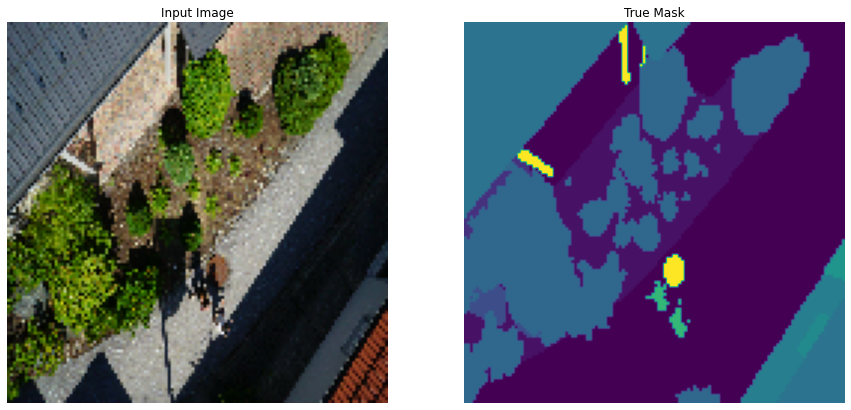

In [26]:
for image, mask in train_batches.take(1):
  sample_image, sample_mask = image[0], mask[0]
  display([sample_image, sample_mask])

## Define the Model

## U-Net

U-Net builds on a previous architecture called the Fully Convolutional Network, or FCN, which replaces the dense layers found in a typical CNN with a transposed convolution layer that upsamples the feature map back to the size of the original input image, while preserving the spatial information. This is necessary because the dense layers destroy spatial information (the "where" of the image), which is an essential part of image segmentation tasks. An added bonus of using transpose convolutions is that the input size no longer needs to be fixed, as it does when dense layers are used. 

Unfortunately, the final feature layer of the FCN suffers from information loss due to downsampling too much. It then becomes difficult to upsample after so much information has been lost, causing an output that looks rough. 

U-Net improves on the FCN, using a somewhat similar design, but differing in some important ways.  Instead of one transposed convolution at the end of the network, it uses a matching number of convolutions for downsampling the input image to a feature map, and transposed convolutions for upsampling those maps back up to the original input image size. It also adds skip connections, to retain information that would otherwise become lost during encoding. Skip connections send information to every upsampling layer in the decoder from the corresponding downsampling layer in the encoder, capturing finer information while also keeping computation low. These help prevent information loss, as well as model overfitting.

In [27]:
def encoder_block(inputs=None, n_filters=32, dropout_prob=0, max_pooling=True):
    """
    Convolutional downsampling block
    
    Arguments:
        inputs -- Input tensor
        n_filters -- Number of filters for the convolutional layers
        dropout_prob -- Dropout probability
        max_pooling -- Use MaxPooling2D to reduce the spatial dimensions of the output volume
    Returns: 
        next_layer, skip_connection --  Next layer and skip connection outputs
    """

    conv = Conv2D(n_filters,
                  3,    
                  activation='relu',
                  padding='same',
                  kernel_initializer='he_normal')(inputs)
    conv = Conv2D(n_filters, # Number of filters
                  3,   # Kernel size
                  activation='relu',
                  padding='same',
                  kernel_initializer='he_normal')(conv)
        
    # if dropout_prob > 0 add a dropout layer, with the variable dropout_prob as parameter
    if dropout_prob > 0:
        conv = Dropout(dropout_prob)(conv)         
        
    # if max_pooling is True add a MaxPooling2D with 2x2 pool_size
    if max_pooling:
        next_layer = MaxPooling2D(pool_size=(2, 2))(conv)        
    else:
        next_layer = conv
        
    skip_connection = conv
    
    return next_layer, skip_connection

In [28]:
def decoder_block(expansive_input, contractive_input, n_filters=32):
    """
    Convolutional upsampling block
    
    Arguments:
        expansive_input -- Input tensor from previous layer
        contractive_input -- Input tensor from previous skip layer
        n_filters -- Number of filters for the convolutional layers
    Returns: 
        conv -- Tensor output
    """
    
    up = Conv2DTranspose(
                 n_filters,    # number of filters
                 3,    # Kernel size
                 strides=2,
                 padding='same')(expansive_input)
    
    # Merge the previous output and the contractive_input
    merge = concatenate([up, contractive_input], axis=3)
    conv = Conv2D(n_filters,   
                 3,     
                 activation='relu',
                 padding='same',
                 kernel_initializer='he_normal')(merge)
    conv = Conv2D(n_filters,  
                 3,   
                 activation='relu',
                 padding='same',
                 kernel_initializer='he_normal')(conv)
    
    return conv

## Build the Model

Building the model involves chaining the encoder, bottleneck, and decoder

In [45]:
def unet_model(input_size=(128, 128, 3), n_filters=32, n_classes=23):
  """
    Unet model
    
    Arguments:
        input_size -- Input shape 
        n_filters -- Number of filters for the convolutional layers
        n_classes -- Number of output classes
    Returns: 
  """

  inputs = Input(input_size)

  # Encoding the input data (downsampling)
  # Increase filters by multiple of 2 for each encoder block
  enc_block1 = encoder_block(inputs, n_filters)
  enc_block2 = encoder_block(enc_block1[0], n_filters * 2)
  enc_block3 = encoder_block(enc_block2[0], n_filters * 4)
  enc_block4 = encoder_block(enc_block3[0], n_filters * 8, dropout_prob=0.3) # Include dropout
  # Include dropout and remove max pooling
  enc_block5 = encoder_block(enc_block4[0], n_filters * 16, dropout_prob=0.3, max_pooling=False) 

  # Decoder the input data (upsampling)
  # Decrease filters by multiple of 2
  dec_block1 = decoder_block(enc_block5[0], enc_block4[1], n_filters * 8)
  # Chain the output of the previous block as expansive_input and the corresponding contractive block output.
  dec_block2 = decoder_block(dec_block1, enc_block3[1], n_filters * 4)
  dec_block3 = decoder_block(dec_block2, enc_block2[1], n_filters * 2)
  dec_block4 = decoder_block(dec_block3, enc_block1[1], n_filters * 1)

  conv1 = Conv2D(n_filters,
                 3,
                 activation='relu',
                 padding='same',
                 kernel_initializer='he_normal')(dec_block4)

  # Add a Conv2D layer with n_classes filter, kernel size of 1 and a 'same' padding
  
  conv2 = Conv2D(n_classes, 1, padding='same')(conv1)
  
  model = tf.keras.Model(inputs=inputs, outputs=conv2)

  return model

### Set Model Dimensions

In [46]:
img_height = 128
img_width = 128
num_channels = 3

unet = unet_model((img_height, img_width, num_channels))

### Check model summary

In [47]:
unet.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_40 (Conv2D)             (None, 128, 128, 32  896         ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_41 (Conv2D)             (None, 128, 128, 32  9248        ['conv2d_40[0][0]']              
                                )                                                           

### Loss Function

In semantic segmentation, as many masks as the object classes are needed. In the dataset, each pixel in every mask has been assigned a signle integer probability that it belongs to a certain class, from `0 to num_classe-1`. The correct class is the layer with the higher probability

This is different from categorical crossentropy, where the labels should be one-hot encoded (just 0s and 1s). `Sparse categorical crossentropy` is used as the loss function, to perform pixel-wise multiclass prediction. `Sparse categorical crossentropy` is more efficient than other loss functions when dealing with lots of classes.

Plot the resulting model architecture:

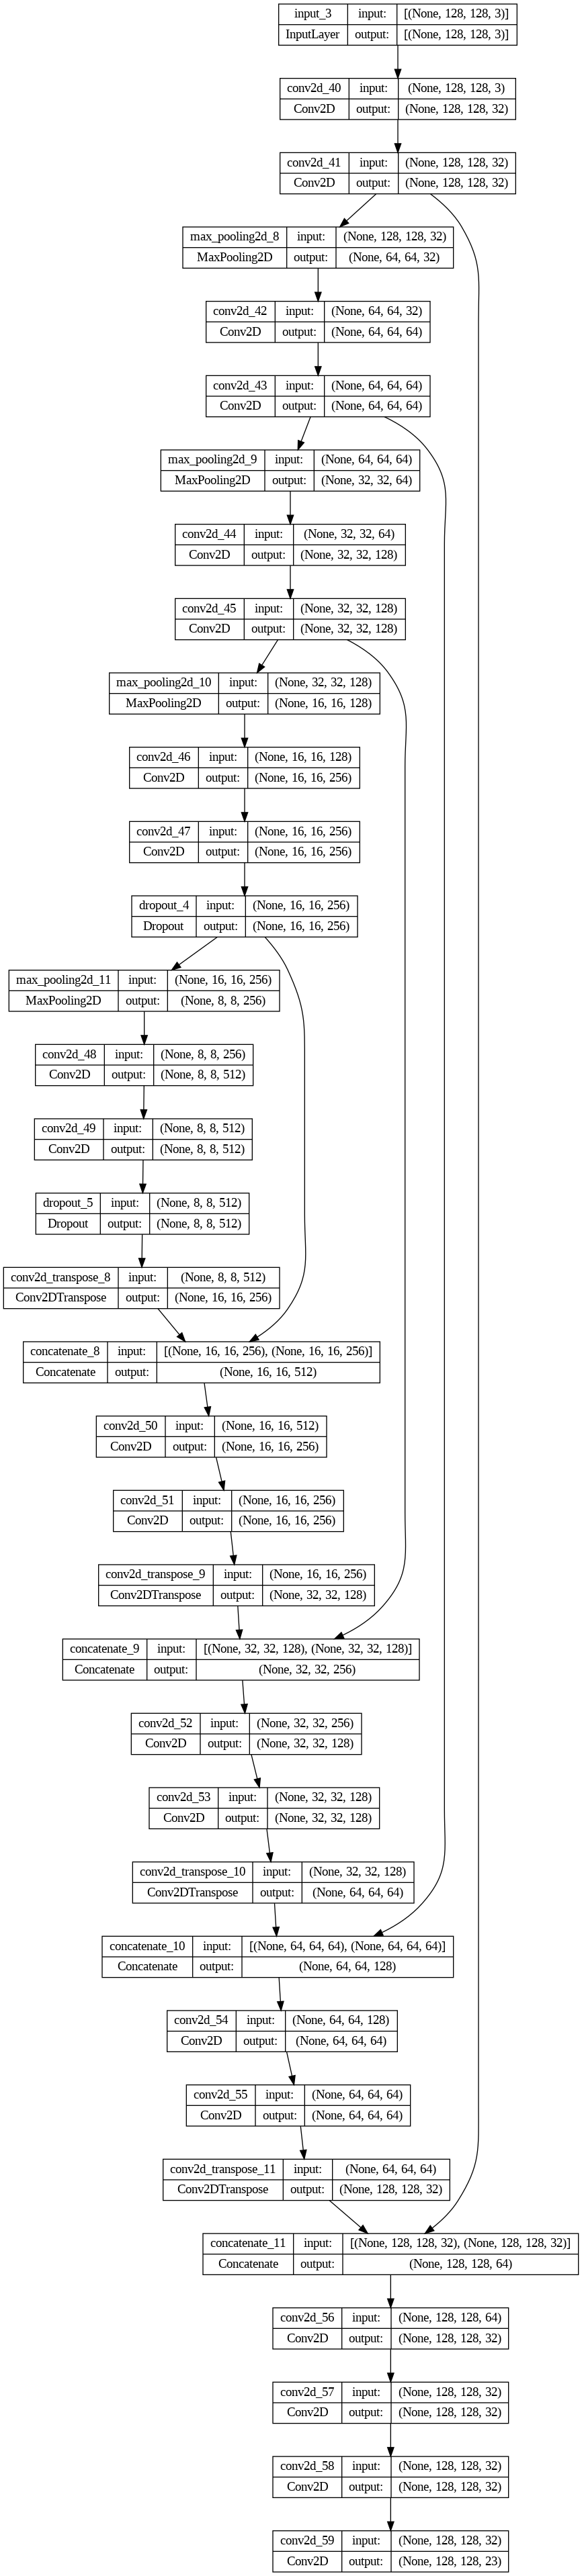

In [48]:
tf.keras.utils.plot_model(unet, show_shapes=True)

Experiment on the model before training to see what it predicts:

In [37]:
def create_mask(pred_mask):
  pred_mask = tf.math.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]

In [38]:
def show_predictions(dataset=None, num=1):
  if dataset:
    for image, mask in dataset.take(num):
      pred_mask = unet.predict(image)
      display([image[0], mask[0], create_mask(pred_mask)])
  else:
    display([sample_image, sample_mask,
             create_mask(unet.predict(sample_image[tf.newaxis, ...]))])

1/1 [==============================] - 9s 9s/step


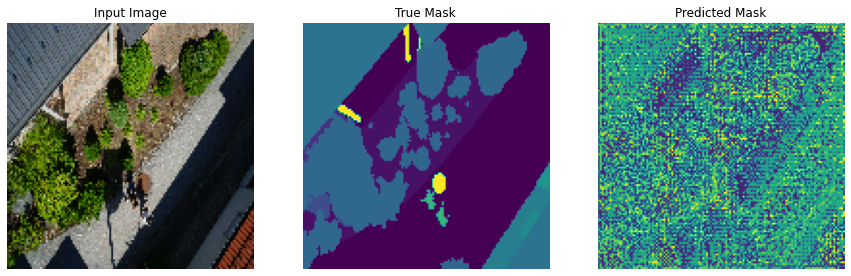

In [39]:
show_predictions()

The following class performs a simple augmentation by randomly-flipping an image. 

Initialize *callbacks* to save the best model

In [40]:
# Create directory to store saved model
!mkdir saved_models

In [60]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        "saved_models/aerial_segment.h5",
        monitor="val_loss",
        save_best_only=True,
        save_weights_only=True),
    
    tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=20)
]

In [71]:
EPOCHS = 100
STEPS_PER_EPOCH = len(train_image_paths) // BATCH_SIZE
VALIDATION_STEPS = len(val_image_paths) // BATCH_SIZE

Compile the model:

In [72]:
unet.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

Train the model:

In [73]:
model_history = unet.fit(train_batches, 
                         steps_per_epoch=STEPS_PER_EPOCH,
                         validation_steps=VALIDATION_STEPS,
                         validation_data=val_batches,
                         epochs=EPOCHS,
                         callbacks=callbacks)

Epoch 1/100
10/10 [==============================] - 208s 9s/step - loss: 1.6353 - accuracy: 0.5535 - val_loss: 1.3301 - val_accuracy: 0.6445
Epoch 2/100
10/10 [==============================] - 35s 4s/step - loss: 1.2021 - accuracy: 0.6549 - val_loss: 1.1863 - val_accuracy: 0.6674
Epoch 3/100
10/10 [==============================] - 43s 5s/step - loss: 1.0690 - accuracy: 0.6820 - val_loss: 1.0895 - val_accuracy: 0.6873
Epoch 4/100
10/10 [==============================] - 43s 5s/step - loss: 0.9882 - accuracy: 0.7027 - val_loss: 1.1298 - val_accuracy: 0.6666
Epoch 5/100
10/10 [==============================] - 36s 4s/step - loss: 0.9458 - accuracy: 0.7134 - val_loss: 1.0474 - val_accuracy: 0.6979
Epoch 6/100
10/10 [==============================] - 34s 4s/step - loss: 0.8641 - accuracy: 0.7346 - val_loss: 0.9964 - val_accuracy: 0.7125
Epoch 7/100
10/10 [==============================] - 43s 5s/step - loss: 0.8138 - accuracy: 0.7474 - val_loss: 1.0074 - val_accuracy: 0.7166
Epoch 8/100


## Plot Model Accuracy

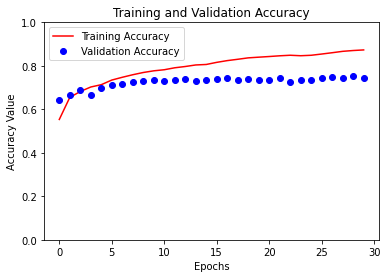

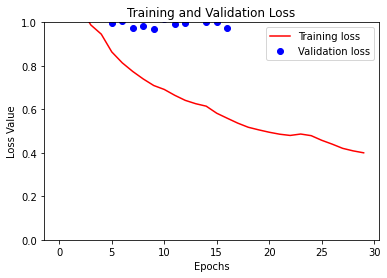

In [76]:
epochs = model_history.epoch

plt.figure()

# Plot Training and Validation Accuracy
acc = model_history.history['accuracy']
val_acc = model_history.history['val_accuracy']

plt.plot(epochs, acc, 'r', label='Training Accuracy')
plt.plot(epochs, val_acc, 'bo', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy Value')
plt.ylim([0, 1])
plt.legend()
plt.show()


# Plot Training and Validation Loss
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'bo', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.show()

## Make Predictions

1/1 [==============================] - 0s 37ms/step


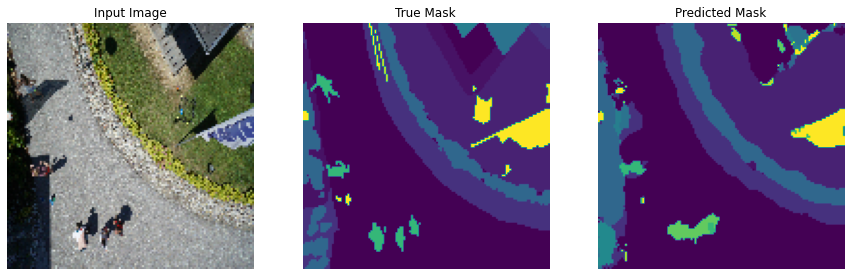

1/1 [==============================] - 0s 78ms/step


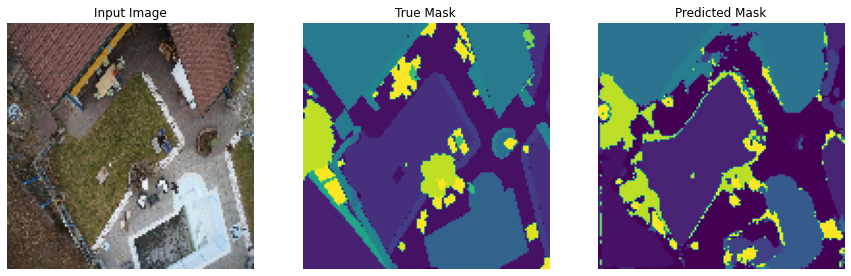

1/1 [==============================] - 0s 24ms/step


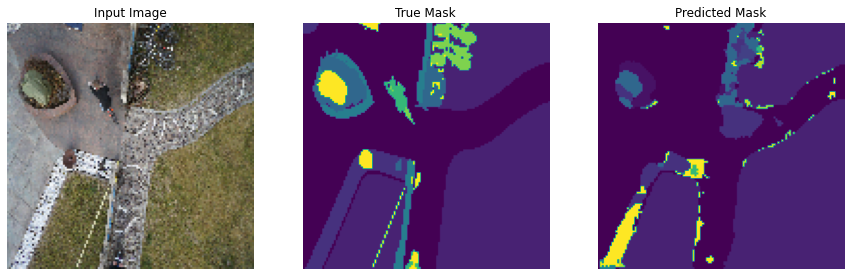

In [95]:
show_predictions(val_batches, 3)